The Multi-Armed Bandit (MAB) is a problem where an agent chooses among several options (arms), each with an unknown reward distribution, with the goal of maximizing cumulative reward over time. There are several ways to solve this problem, including Epsilon Greedy and Upper Confidence Bound (UCB). Let’s go through both:

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the distributions
class Arms:
    def __init__(self, type, param1, param2):
        self.type = type
        self.param1 = param1
        self.param2 = param2

    def get_reward(self):
        if self.type == 'uniform':
            return np.random.uniform(self.param1, self.param2)
        if self.type == 'gaussian':
            return np.random.normal(self.param1, self.param2)
        if self.type == 'exponential':
            return np.random.exponential(1.0 / self.param1)
        if self.type == 'beta':
            return np.random.beta(self.param1, self.param2)


In [2]:
arm1 = Arms('uniform', 5, 10)
arm2 = Arms('gaussian', 6, 2)
arm3 = Arms('exponential', 1/4, 0)
arm4 = Arms('beta', 2, 5)
arm5 = Arms('uniform', -5, 0)
arm6 = Arms('gaussian', 10, 6)
arm7 = Arms('exponential', 1/7, 0)
arm8 = Arms('beta', 5, 2) 

arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]

In epsilon greedy, we define a number epsilon which dictates how often we explore and exploit.  
Eploration consists of choosing a random arm and getting more information whilst exploiting is choosing the arm that you know gives the maximum rewards (based on the information you have so far).

In [87]:
class EpsilonGreedy:
    def __init__(self, arms, epsilon, steps):
        self.arms = arms
        self.epsilon = epsilon
        self.steps = steps
        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros(len(arms)) # Estimated rewards of all arms
        self.action_count = np.zeros(len(arms)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []

    def select_action(self, epsilon):
        # TODO: Implement epsilon greedy approach of choosing arms here
        # Return action chosen (which arm to pick)
        if np.random.rand() < epsilon:
            return np.random.randint(0, len(arms))
        else:
            return np.argmax(self.estimated_rewards)

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here

        self.action_count[action] += 1

        #just the average of all the previous reward, target stationary so works 
        self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])

        self.rewards.append(reward)
        self.total_reward += reward

    def run(self, decay=1):
        
        epsilon=self.epsilon
        for _ in range(self.steps):
            
            action = self.select_action(epsilon)
            reward = self.arms[action].get_reward()
            self.update(action, reward)

            epsilon *= decay

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 1748.1930469871684
Estimated means: [ 7.39119563  5.9347138   1.85893047  0.22129852 -2.30097499 10.04988871
  5.22171128  0.82231041]


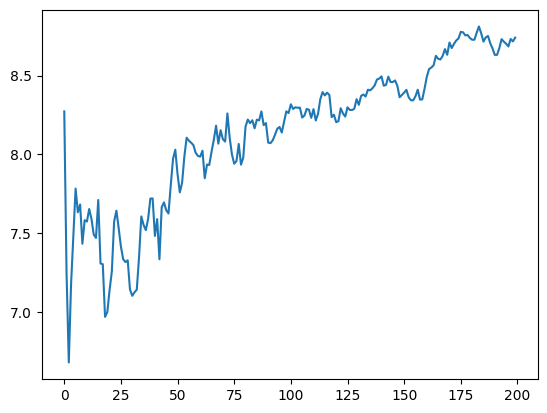

In [84]:
steps = 200
epsilon = 0.15 # Play around with this value

banditEG = EpsilonGreedy(arms, epsilon, steps)
total_reward, estimated_reward, rewards = banditEG.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)
plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()


### Trying different epsilons

Max reward: 1598.3924851960423, At i: 2


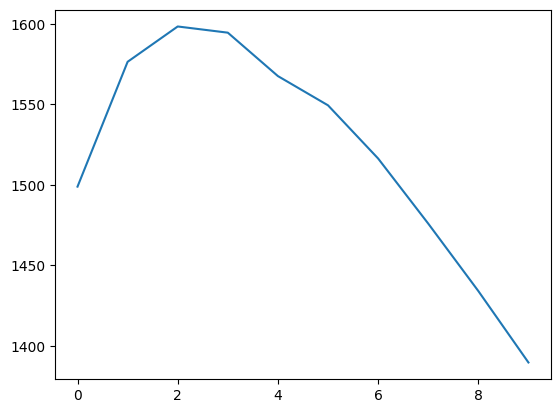

In [94]:
results = []
steps = 200
reward = 0

for i in range(10):
    reward  =0

    for j in range(1000):
        banditEG = EpsilonGreedy(arms, 0.05*i, steps)
        total_reward, estimated_reward, rewards = banditEG.run()
        reward += (1/(j+1))*(total_reward - reward)

    results.append(reward)

plt.plot(results)
print(f"Max reward: {np.max(results)}, At i: {np.argmax(results)}")
# plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

epsilon = 0.1 - 0.15 works best

### Trying epsilon decay

starting from e = 1

Max reward: 1715.7381930156942, At i: 5


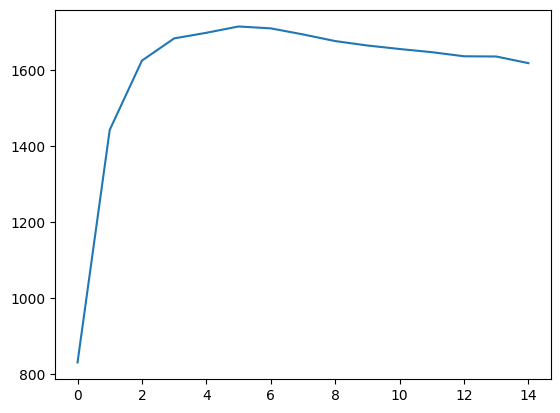

In [93]:
results = []
steps = 200
reward = 0

for i in range(15):
    reward = 0

    for j in range(1000):
        banditEG = EpsilonGreedy(arms, 1, steps)
        total_reward, estimated_reward, rewards = banditEG.run(decay=1-0.01*i)
        reward += (1/(j+1))*(total_reward - reward)

    results.append(reward)

plt.plot(results)
print(f"Max reward: {np.max(results)}, At i: {np.argmax(results)}")
# plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

e = 1, decay = 0.95 works better than e = 0.1

In upper confidence bound, we have the upper confidence estimate where we use both the estimated mean and the number of times we have picked that option. The more times you have chosen something, the more certain you are of its estimated mean. Using this we have 2 terms, the estimated mean and the confidence score. The constant c dictates how much the confidence score affects our choice.

$UCB_t(a) = \hat{Q}_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}}$  
$\hat{Q}_t(a)$ is the estimated reward. $N_t(a)$ is the number of times arm $a$ has been picked and $t$ is the timestamp

In [105]:
class UpperConfidenceBound:
    def __init__(self, arms, steps, c):
        self.arms = arms
        self.steps = steps
        self.c = c
        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros(len(arms)) # Estimated rewards of all arms
        self.action_count = np.zeros(len(arms)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []

    def select_action(self, t):
        # TODO: First, play each arm at least once.
        # Compute the UCB values for each arm and choose accordingly

        if np.all(self.action_count!=0):

            UCB = self.estimated_rewards + self.c*np.sqrt(np.log(t)/self.action_count)
            return np.argmax(UCB)
        
        else:

            return np.argwhere(self.action_count==0)[0][0]

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        
        self.action_count[action] += 1

        #just the average of all the previous reward, target stationary so works 
        self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])

        self.rewards.append(reward)
        self.total_reward += reward

    def run(self):
        for t in range(self.steps):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 1919.031408104046
Estimated means: [ 7.46683884e+00  6.07041165e+00  2.46001583e+00  3.17699276e-03
 -4.30247872e+00  1.02970774e+01  6.30192404e+00  5.99752030e-01]


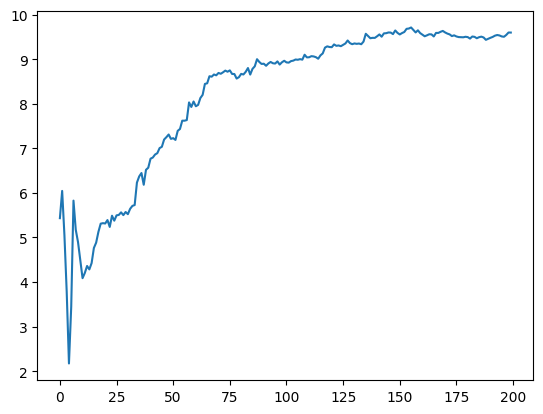

In [149]:
steps = 200
c = 4 # Play around with this value

banditUCB = UpperConfidenceBound(arms, steps, c)
total_reward, estimated_reward, rewards = banditUCB.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)
plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

### Trying different c

Max reward: 1821.2515272934475, At i: 8


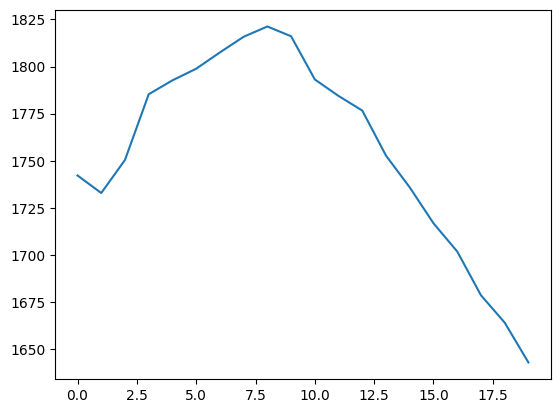

In [ ]:
results = []
steps = 200
reward = 0

for i in range(20):
    reward  =0

    for j in range(1000):
        banditUCB = UpperConfidenceBound(arms, steps, 0.5*i)
        total_reward, estimated_reward, rewards = banditUCB.run()
        reward += (1/(j+1))*(total_reward - reward)

    results.append(reward)

plt.plot(results)
print(f"Max reward: {np.max(results)}, At i: {np.argmax(results)}")
# plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

for c = 4 UCB works better than EG

## Optional challenges

1. if you already know the distribution the arms draw from(eg: gaussian), can you incorporate that knowledge to learn faster

We will host a competition where we will run your agents and host a leaderboard(details in the next meet)

In [160]:
class ExtraKnowledge:
    def __init__(self, arms, steps, c):
        self.arms = arms
        self.steps = steps
        self.c = c

        self.info = []
        for arm in arms:
            match arm.type:
                case "uniform":
                    self.info.append([-1000,1000])

                case "gaussian":
                    self.info.append([-1000,1000])

                case "exponential":
                    self.info.append([-1000,1000])

                case "beta":
                    self.info.append([-1000,1000])

        # TODO: Initialize parameters
        self.estimated_rewards = np.zeros(len(arms)) # Estimated rewards of all arms
        self.action_count = np.zeros(len(arms)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []

    def select_action(self, t):
        # TODO: First, play each arm at least once.
        # Compute the UCB values for each arm and choose accordingly

        if np.all(self.action_count!=0):

            UCB = self.estimated_rewards + self.c*np.sqrt(np.log(t)/self.action_count)
            return np.argmax(UCB)
        
        else:

            return np.argwhere(self.action_count==0)[0][0]

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        
        self.action_count[action] += 1

        #just the average of all the previous reward, target stationary so works 
        # self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])
        match self.arms[action].type:
            case "uniform":
                self.info[action][0] = max(self.info[action][0], reward) 
                self.info[action][1] = min(self.info[action][1], reward) 

                self.estimated_rewards[action] = (self.info[action][0]+self.info[action][1])/2
                
                self.rewards.append(reward)
                self.total_reward += reward

                return
                
            case "gaussian":
                self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])

                self.rewards.append(reward)
                self.total_reward += reward

                return
            case "exponential":
                self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])

                self.rewards.append(reward)
                self.total_reward += reward

                return
            case "beta":
                self.estimated_rewards[action] += (1/self.action_count[action])*(reward - self.estimated_rewards[action])

                self.rewards.append(reward)
                self.total_reward += reward

                return
            


    def run(self):
        for t in range(self.steps):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 1838.8896320055615
Estimated means: [ 7.7209382   5.98315444  1.12069198  0.05372802 -4.96295903  9.64938128
  3.37164069  0.58079787]


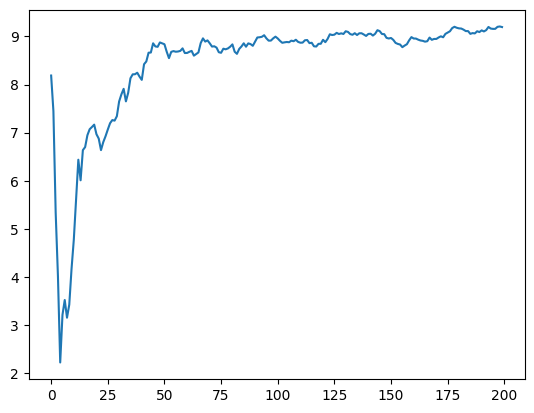

In [178]:
steps = 200
c = 3.5 # Play around with this value

banditEK = ExtraKnowledge(arms, steps, c)
total_reward, estimated_reward, rewards = banditEK.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)
plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

Max reward: 1820.8642338866296, At i: 7


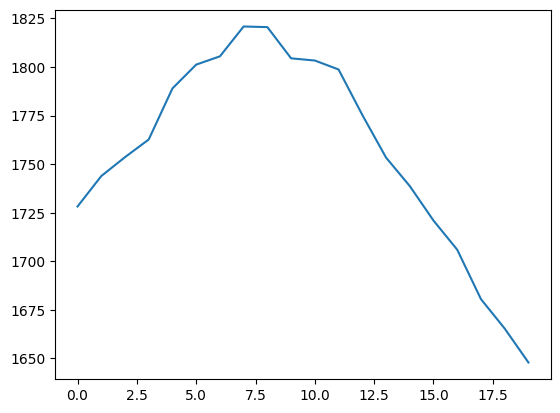

In [180]:
results = []
steps = 200
reward = 0

for i in range(20):
    reward  =0

    for j in range(1000):
        banditEK = ExtraKnowledge(arms, steps, 0.5*i)
        total_reward, estimated_reward, rewards = banditEK.run()
        reward += (1/(j+1))*(total_reward - reward)

    results.append(reward)

plt.plot(results)
print(f"Max reward: {np.max(results)}, At i: {np.argmax(results)}")
# plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

Max reward: 1827.93768796227, At i: 5


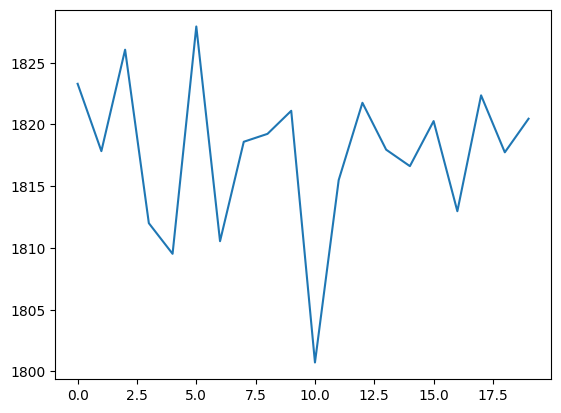

In [179]:
results = []
steps = 200
reward = 0

for i in range(20):
    reward  =0

    for j in range(1000):
        banditEK = ExtraKnowledge(arms, steps, 3.5)
        total_reward, estimated_reward, rewards = banditEK.run()
        reward += (1/(j+1))*(total_reward - reward)

    results.append(reward)

plt.plot(results)
print(f"Max reward: {np.max(results)}, At i: {np.argmax(results)}")
# plt.plot(np.cumsum(rewards)/np.arange(start=1, stop=steps+1))
plt.show()

with such variance the difference in this and UCB is not significant